## Fitting upper limit of RV amplitude

In [1]:
# https://exofop.ipac.caltech.edu/tess/target.php?id=470381900
Porb = 2.50071474655903, 0.000511482
tc = 2458816.697706, 0.0027523146

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def phase_fold(time, rv_val, rv_err, P, tc=0):
    
    fold = (time-tc) % P
    phase_sort = np.argsort(fold)

    phase_time = fold[phase_sort]
    phase_rv_val = rv_val[phase_sort]
    phase_rv_err = rv_err[phase_sort]
    
    return phase_time, phase_rv_val, phase_rv_err

skips first data point that is 

In [3]:
import pandas as pd

fp = "../data/rv/TOI1696_rv_all.dat"
df = pd.read_csv(fp,
#                  skiprows=[1] # <------------------first datapoint is problematic!
                )
df['rv'] = df['rv']*1000
df['rv_err'] = df['rv_err']*1000
df

,bjd,rv,rv_err
0,2.459245e+06,-81.987,8.17
1,2.459488e+06,46.578,7.02
2,2.459508e+06,57.321,9.29
3,2.459508e+06,25.829,7.04
4,2.459510e+06,63.226,8.91
5,2.459510e+06,0.000,7.32
6,2.459515e+06,-14.359,8.18
7,2.459515e+06,-29.625,7.20
8,2.459531e+06,-79.214,8.25


In [4]:
#other data points are 20, 15 days apart
df.bjd.diff()

0           NaN
1    243.066250
2     19.961093
3      0.149916
4      1.825067
5      0.170287
6      4.860434
7      0.198360
8     15.721695
Name: bjd, dtype: float64

## test dataset
* uncomment below to test RV model

<AxesSubplot:xlabel='bjd'>

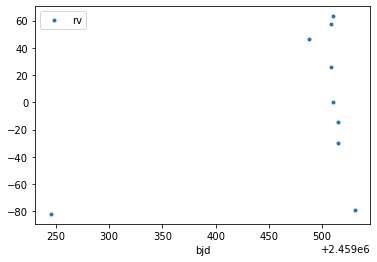

In [5]:
df.plot(x='bjd',y='rv',marker='.',ls='')

<ErrorbarContainer object of 3 artists>

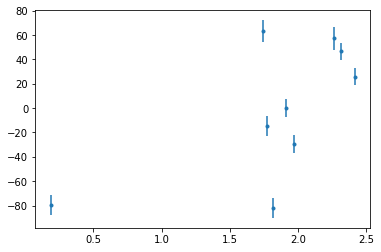

In [6]:
phase_time, phase_rv_val, phase_rv_err = phase_fold(df.bjd.values, 
                                                    df.rv.values, 
                                                    df.rv_err.values, 
                                                    P=Porb[0],
                                                    tc=tc[0]+Porb[0]/2
                                                   ) 
plt.errorbar(phase_time, phase_rv_val, yerr=phase_rv_err, fmt='.')

## periodogram

In [7]:
import pandas as pd
import astropy.units as u
from astropy.timeseries import LombScargle

# rc('figure', figsize=(13,4))

In [8]:
ls = LombScargle(df['bjd'], df['rv'])

In [9]:
# frequency, power = ls.autopower(minimum_frequency=1/(5*u.d), maximum_frequency=2/u.d)
frequency, power = ls.autopower(minimum_frequency=1/5, maximum_frequency=2)
period = 1/frequency

In [10]:
best_period = period[np.argmax(power)]
best_period

1.9970100087167897

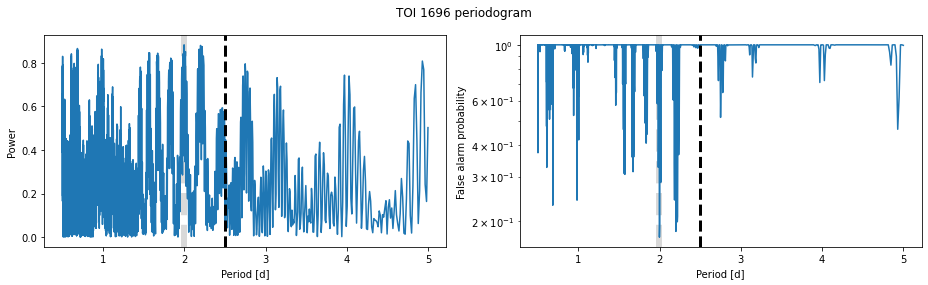

In [11]:
target = 'TOI 1696'

fig, axs = plt.subplots(1, 2, figsize=(13,4))
axs[0].plot(period, power)
axs[0].axvline(Porb[0], 0, 1, ls='--', lw=3, c='k')
axs[1].semilogy(period, ls.false_alarm_probability(power))
axs[1].axvline(Porb[0], 0, 1, ls='--', lw=3, c='k')
[ax.axvline(best_period, c='k', ls='--', zorder=-1, lw=6, alpha=0.15) for ax in axs]
plt.setp(axs, xlabel='Period [d]')
plt.setp(axs[0], ylabel='Power')
plt.setp(axs[1], ylabel='False alarm probability')
fig.suptitle(f'{target} periodogram')
fig.tight_layout()

Periodogram cannot detect the period from transit

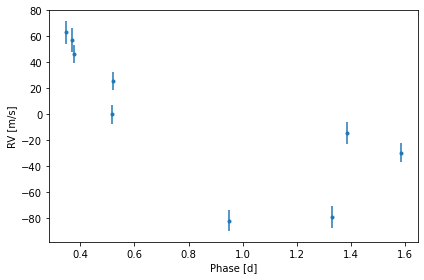

In [12]:
fig, ax = plt.subplots()
ax.errorbar(df['bjd'] % best_period, df['rv'], df['rv_err'], fmt='.')
plt.setp(ax, xlabel='Phase [d]', ylabel='RV [m/s]')
fig.tight_layout()

In [27]:
from pytransit.lpf.rvlpf import RVLPF

lpf = RVLPF(target, 
            nplanets=1, 
            times=df['bjd'].values,#*u.day, 
            rvs=df['rv'].values,#*u.m/u.second, 
            rves=df['rv_err'].values,#*u.m/u.second
           )
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 1.0)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

In [28]:
offset = Porb[0]/2
# lpf.set_prior('tc_1', 'NP', tc[0]+offset, tc[1]+offset)  # Normal prior (mean, sigma)
lpf.set_prior('p_1', 'NP', *Porb)
lpf.set_prior('secw_1', 'NP', 0, 0.01)
lpf.set_prior('sesw_1', 'NP', 0, 0.01)
lpf.set_prior('rv_shift_0', 'UP', -100, 100)   # 
lpf.set_prior('rv_err_0', 'UP', 0.0, 200)      # 
lpf.set_prior('rv_k_1', 'UP', 0.0, 1000)        #
lpf.set_prior('rv_slope', 'NP', 0, 0.1)
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 2.50071474655903, σ = 0.000511482) [    0.00 ..      inf],
   2 |G| secw_1         N(μ = 0.0, σ = 0.01)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         N(μ = 0.0, σ = 0.01)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     U(a = -100, b = 100)                     [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 200)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 1000)                     [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf]]

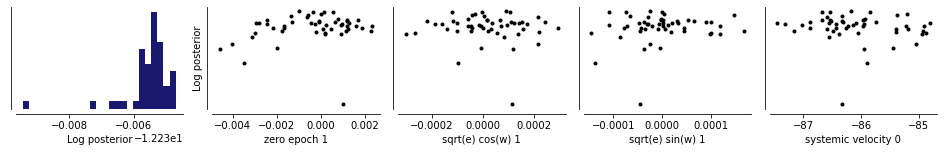

In [29]:
lpf.optimize_global(5000)

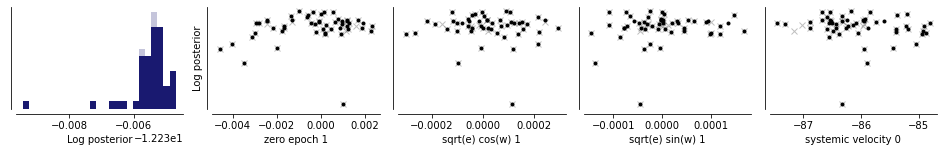

In [30]:
lpf.optimize_global(1000)

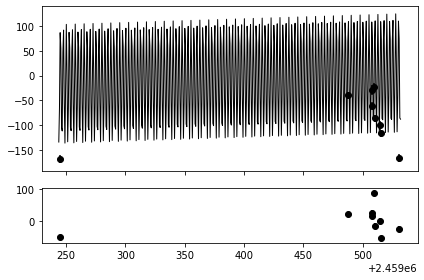

In [31]:
lpf.plot_rv_vs_time();

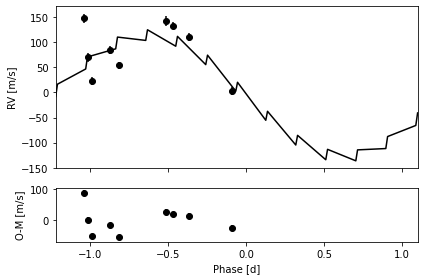

In [32]:
lpf.plot_rv_vs_phase(0);

## mcmc

In [33]:
lpf.sample_mcmc(niter=5000, thin=10, repeats=2)

## posterior model

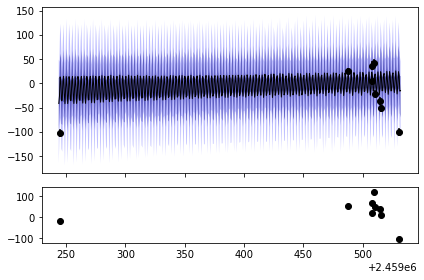

In [34]:
lpf.plot_rv_vs_time('mcmc');

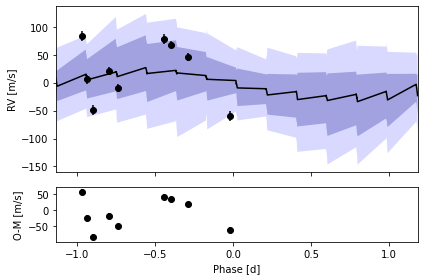

In [35]:
fig = lpf.plot_rv_vs_phase(0, 'mcmc')
# fig.axes[0].add_patch(Rectangle((-.02, -25), 0.04, 50, fill=False));

In [36]:
df2 = lpf.posterior_samples()
df2

,tc_1,p_1,secw_1,sesw_1,rv_shift_0,rv_err_0,rv_k_1,rv_slope
0,-0.002040,2.500288,0.009587,-0.002640,-91.537487,54.339386,131.091235,0.025013
1,-0.002040,2.500288,0.009587,-0.002640,-91.537487,54.339386,131.091235,0.025013
2,-0.002040,2.500288,0.009587,-0.002640,-91.537487,54.339386,131.091235,0.025013
3,-0.002040,2.500288,0.009587,-0.002640,-91.537487,54.339386,131.091235,0.025013
4,-0.002040,2.500288,0.009587,-0.002640,-91.537487,54.339386,131.091235,0.025013
...,...,...,...,...,...,...,...,...
24995,-0.006335,2.500376,0.011740,-0.005690,-24.471540,50.546268,7.284474,0.069916
24996,-0.039315,2.500325,0.012860,-0.006048,-23.166274,52.630060,2.223295,0.051867
24997,-0.040654,2.500313,0.012464,-0.005929,-22.716152,52.557473,3.951110,0.052222
24998,-0.124643,2.500430,0.019475,-0.007961,-7.042521,71.262065,7.833301,0.015987


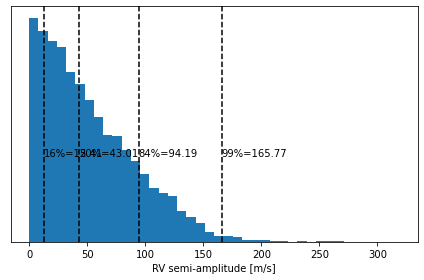

In [37]:
fig, ax = plt.subplots()
ax.hist(df2.rv_k_1, bins=40)
# ax.axvline(np.median(df2.rv_k_1), c='k')
pctls = [16,50,84,99]
vals = np.percentile(df2.rv_k_1, pctls)
for p,v in zip(pctls,vals):
    ax.axvline(v, 0, 1, ls='--', c='k')
    ax.text(v, 1000,f"{p}%={v:.2f}")
plt.setp(ax, xlabel='RV semi-amplitude [m/s]', yticks=[])
fig.tight_layout()

In [38]:
lpf.ps.names

['tc_1',
 'p_1',
 'secw_1',
 'sesw_1',
 'rv_shift_0',
 'rv_err_0',
 'rv_k_1',
 'rv_slope']

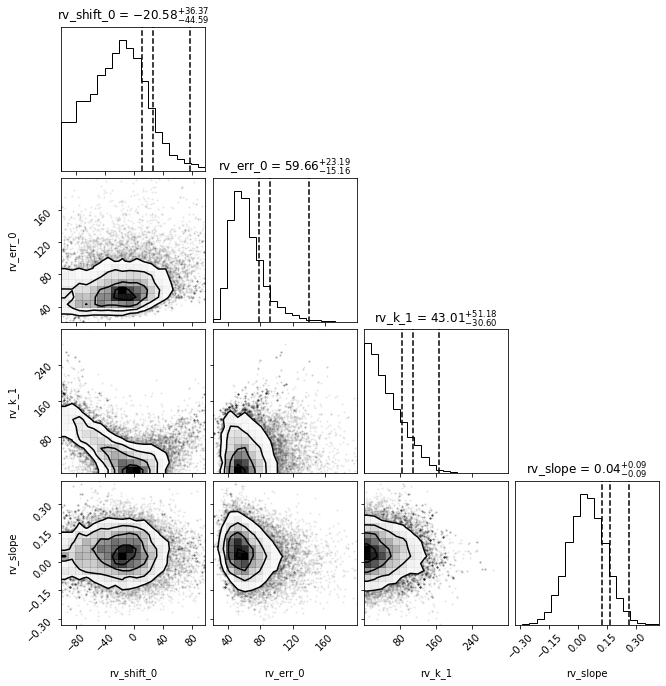

In [39]:
from corner import corner

cols = 'rv_shift_0 rv_err_0 rv_k_1 rv_slope'.split()
fig = corner(df2[cols], labels=cols, show_titles=True, quantiles=[0.80,0.90,0.99]);